# RedHat Kaggle Model

In [1]:
## load necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
from ipywidgets import interact
import seaborn as sb
sb.set(context='talk', style='darkgrid', palette='muted')

libDir = r"/Users/washington_zjq/Dropbox/Kaggle/RedHat/lib"
import sys
sys.path.insert(0, libDir)
from dbutil import getData

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Background

Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.

In this competition, Kagglers are challenged to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.

With an improved prediction model in place, Red Hat will be able to more efficiently prioritize resources to generate more business and better serve their customers.

[Kaggle Link](https://www.kaggle.com/c/predicting-red-hat-business-value)

## Descriptions of Data

This competition uses two separate data files that may be joined together to create a single, unified data table: a people file and an activity file.

### People File

The people file contains all of the unique people (and the corresponding characteristics) that have performed activities over time. Each row in the people file represents a unique person. Each person has a unique people_id.

In [2]:
people = getData('People')

By exploring the people file, char_10 to char_37 are all boolean variables. In this case, we will map the TRUE to be 1 and FALSE to be 0.

In [3]:
bol_cols = ['char_{}'.format(i) for i in range(10, 38)]

In [4]:
for col in bol_cols: 
    people[col] = people[col].map({False: 0, True:1})

### Activity File

The activity file contains all of the unique activities (and the corresponding activity characteristics) that each person has performed over time. Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id.

The challenge of this competition is to predict the potential business value of a person who has performed a specific activity. The business value outcome is defined by a yes/no field attached to each unique activity in the activity file. The outcome field indicates whether or not each person has completed the outcome within a fixed window of time after each unique activity was performed.

The activity file contains several different categories of activities. Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).

In [5]:
act_train = getData('Activity Train')

**Note: char_10 represents the characteristics of type 2-7 activities and char_1 to char_9 describes the type 1 activity**

Since the characteristics names are overlapping between activities and people, we will rename the activities ones as act_char_1 to act_char_10

In [6]:
rename_cols_dict = dict(zip(['char_{}'.format(i) for i in range(1, 11)],
                            ['act_char_{}'.format(i) for i in range(1, 11)]))

In [7]:
act_train = act_train.rename(columns=rename_cols_dict)

In addition, the date name is also the same so it will be renamed as act_date

In [8]:
act_train = act_train.rename(columns={'date': 'act_date'})

To develop a predictive model with this data, you will likely need to join the files together into a single data set. The two files can be joined together using person_id as the common key. All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

In [9]:
train = act_train.join(people.set_index('people_id'), on='people_id')
del act_train
del people

## Data Exploration

### Date investigation

In this section, we will be investigating in the date factor that impacts the final outcome. First let's just make some convertion in the date information (extract month, year, day and day of the week information).

In [23]:
dateInvest = train[['activity_id', 'people_id', 'act_date', 'date', 'outcome']].copy()

In [24]:
dateInvest['act_day_of_week'] = dateInvest.act_date.dt.dayofweek
dateInvest['act_month'] = dateInvest.act_date.dt.month
dateInvest['act_year'] = dateInvest.act_date.dt.year
dateInvest['act_day'] = dateInvest.act_date.dt.day

First of all, we want to see if there is any impact between number of outcome 1 and day of the week.

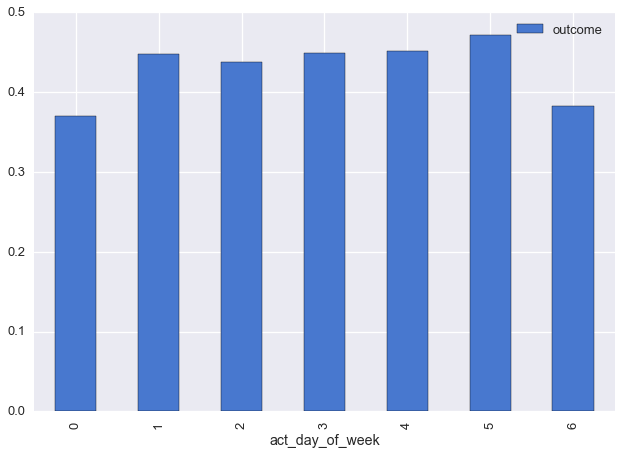

In [42]:
@interact
def viewDayWeekSummary(viewType={'Overall': 1, 'ByYear': 2, 'ByMonth': 3, 'ByYearMonth': 4}, year={'2022': 2022, '2023': 2023}, month=(1, 12)):
    if viewType == 1:
        dayOfWeekSum = dateInvest.groupby(['act_day_of_week']).agg({'outcome': np.mean})
    elif viewType == 2:
        dayOfWeekSum = dateInvest[dateInvest.act_year==year].groupby(['act_day_of_week']).agg({'outcome': np.mean})
    elif viewType == 3:
        dayOfWeekSum = dateInvest[dateInvest.act_month==month].groupby(['act_day_of_week']).agg({'outcome': np.mean})
    elif viewType == 4:
        dayOfWeekSum = dateInvest[(dateInvest.act_year==year)&(dateInvest.act_month==month)].groupby(['act_day_of_week']).agg({'outcome': np.mean})
    try:
        dayOfWeekSum.plot(kind='bar')
    except:
        print 'no month info'

Base on the information by day of the week, we can clearly see Monday and Sunday. 

### Activity Type Analysis

Type 1 activity has more characteristics associated with it than other types so it is interesting to check it out.

In [59]:
act_types = ['type {}'.format(i) for i in range(1, 7)]
char_types = ['act_char_{}'.format(i) for i in range(1, 11)]

In [68]:
for i in char_types:
        train[i] = train[i].fillna('type -999').str.replace('type ', '').astype(int)

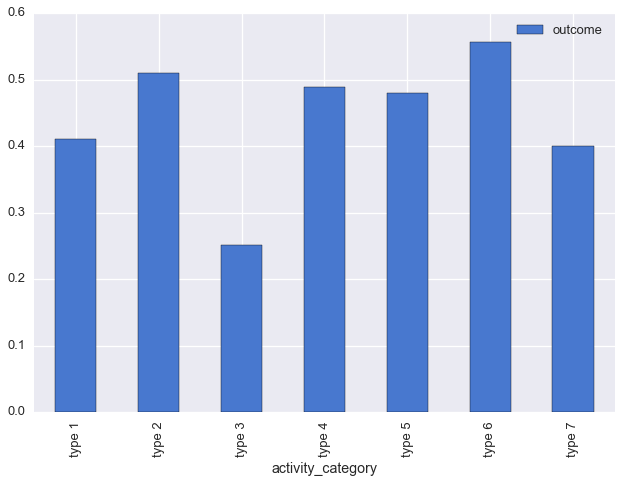

In [71]:
@interact
def viewActivitySum(view_type={'ByAct': 1, 'ByActChar': 2}, act_type=act_types, char_type=char_types):
    if view_type == 1:
        summary = train.groupby('activity_category').agg({'outcome': np.mean})
        summary.plot(kind='bar')
    else:
        if act_type == 'type 1' and char_type == 'act_char_10':
            print 'no info'
        elif act_type != 'type 1' and char_type != 'act_char_10':
            print 'no info'
        else:
            summary = train[train.activity_category==act_type].groupby(char_type).agg({'outcome': np.mean})
            summary.plot()
            

### People Characteristics Analysis

As mentioned, char_38 is continuous and char_10 to char_37 are all boolean variables. Hence, it will be interesting to look at the behaviors of char_1 to char_9 and char_38.

In [41]:
char_cols_to_inv = ['char_{}'.format(i) for i in range(1, 10)]
char_cols_to_inv.append('char_38')

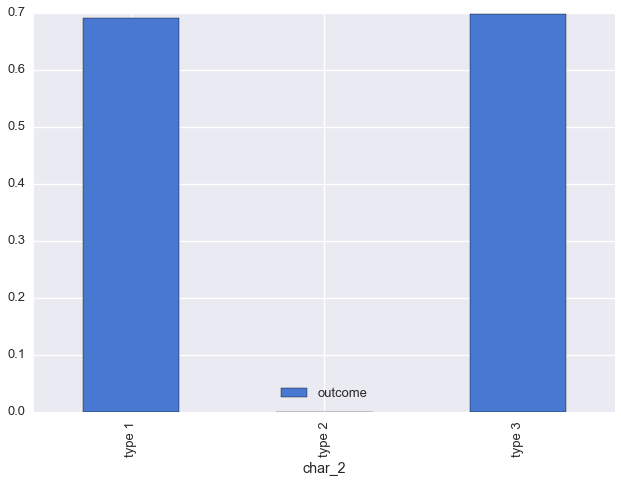

In [45]:
@interact
def viewDist(col=char_cols_to_inv):
    summary = train.groupby(col).agg({'outcome': np.mean})
    summary.plot(kind='bar')

char_2 is better to view as a categorical and for the rest let's treat them as continuous by removing 'type '. 

In [49]:
for i in char_cols_to_inv:
    if i not in ['char_2', 'char_38']:
        train[i] = train[i].str.replace('type ', '').astype(int)

In [55]:
train['char_2'] = train['char_2'].astype('category')

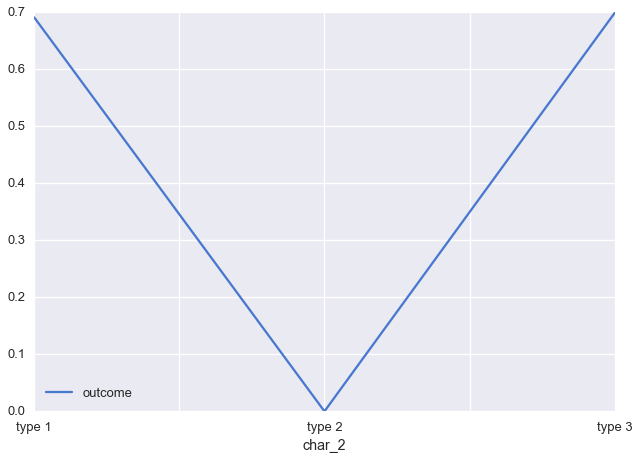

In [56]:
@interact
def viewDist(col=char_cols_to_inv):
    summary = train.groupby(col).agg({'outcome': np.mean})
    summary.plot()

## Modeling

## Model Metrics